In [51]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/ubuntu/.jupyter/"
cm = BaseJSONConfigManager(config_dir=path)
cm.update('livereveal', {
              'theme': 'beige',
              'transition': 'cube',
              'start_slideshow_at': 'selected',
})

{u'start_slideshow_at': 'selected', u'theme': 'beige', u'transition': 'cube'}

In [52]:
%matplotlib inline

import matplotlib
import numpy as np

import shapely
import shapely.geometry
from shapely.geometry import shape
from shapely.geometry import Point, LineString, Polygon, MultiPolygon 
from shapely.wkt import dumps, loads
from shapely.wkb import dumps, loads
import sys
import MySQLdb
import sqlalchemy
import os
import csv
from sqlalchemy import *
from sqlalchemy.orm import *
from sqlalchemy.ext.declarative import declarative_base
import geoalchemy2

from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
#import pysal
import pylab as pl

In [53]:
import random


#grab a random color for coloring a figure
def get_random_color():
    r = lambda: random.randint(0,255)
    return('#%02X%02X%02X' % (r(),r(),r()))

#initialize the figure and draw the shape
def plot(shapelyGeometries, color_dict={"fill":"#AADDCC", "line":"#666666","hole_fill":"#ffffff", "hole_line":"#999999" }):
    'Plot shapelyGeometries'
    figure = pl.figure(num=None, figsize=(2, 2), dpi=180)
    axes = pl.axes()
    axes.set_aspect('equal', 'datalim')
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    
    draw(shapelyGeometries, color_dict)
            
#Check the type and break up multipolygons        
def draw(gs, color_dict):
    'Draw shapelyGeometries'
    # Handle single and lists of geometries
    try:
        gs = iter(gs)
    except TypeError:
        gs = [gs]
    #Route polygons and multipolygons to the right place
    for g in gs:
        gType = g.geom_type
        if gType.startswith('Multi') or gType == 'GeometryCollection':
            draw(g.geoms, color_dict)
        else:
            draw_(g, color_dict)

#Break the shape into its interior and exterior rings            
def draw_(g, color_dict):

    'Draw a shapelyGeometry; thanks to Sean Gilles'
    gType = g.geom_type
    if gType == 'Point':
        pl.plot(g.x, g.y, 'k,')
    elif gType == 'LineString':
        x, y = g.xy
        pl.plot(x, y, 'b-', color=color_dict["line"])
    elif gType == 'Polygon':
        #can draw parts as multiple colors
        if not color_dict:
            color_dict={"fill":get_random_color(), 
                        "line":"#666666",
                        "hole_fill":"#FFFFFF", 
                        "hole_line":"#999999" }
    
    
        x, y = g.exterior.xy
        pl.fill(x, y, color=color_dict["fill"], aa=True) 
        pl.plot(x, y, color=color_dict["line"], aa=True, lw=1.0)
        for hole in g.interiors:
            x, y = hole.xy
            pl.fill(x, y, color=color_dict["hole_fill"], aa=True) 
            pl.plot(x, y, color=color_dict["hole_line"], aa=True, lw=1.0)
            

# Geospatial Analytics in Python

&nbsp;
### Alison Alvarez
### CEO and Co-Founder of BlastPoint
    

## Why care about geospatial data?

- It's an intuitive and incredibly powerful way of understanding the world

- Existing tools are pretty terrible and expensive

- Geospatial skills are rare and valuable

## Why am I qualified to talk about this?

- I spent years building big data tools for giant companies

- I invented several new ways to interact with geospatial data (we can talk about this later)

- I founded a company that uses geospatial data to make data more accessible

### Let's start with the spatial stuff and leave the 'geo' part for later.

### First, we start with a point...

POINT (-79.94710909999999 40.4082978)


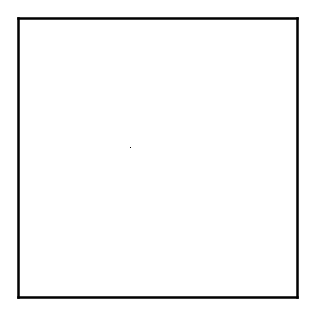

In [54]:
lat = float(40.4082978)
lng = float(-79.94710909999999)

my_point = Point(lng, lat)
print my_point
plot(my_point)

### That doesn't look like very much...

## ENHANCE!!

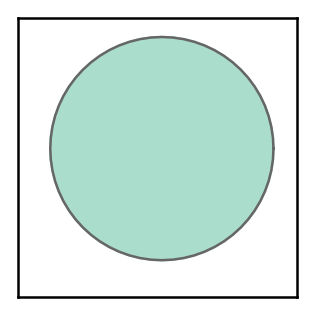

In [55]:
radius = my_point.buffer(.01)
plot(radius)

## Let's see what that looks like in text...

In [56]:
print radius

POLYGON ((-79.93710909999999 40.4082978, -79.93715725273327 40.4073176285967, -79.93730124719596 40.40634689677984, -79.93753969664267 40.40539495322746, -79.93787030467487 40.40447096567635, -79.9382898873565 40.40358383263174, -79.93879440387697 40.4027420976698, -79.93937899546637 40.40195386715836, -79.94003803218813 40.40122673218814, -79.94076516715836 40.40056769546637, -79.94155339766979 40.39998310387698, -79.94239513263173 40.39947858735652, -79.94328226567634 40.39905900467489, -79.94420625322745 40.39872839664267, -79.94515819677983 40.39848994719597, -79.94612892859669 40.39834595273328, -79.94710909999999 40.3982978, -79.94808927140329 40.39834595273328, -79.94906000322015 40.39848994719597, -79.95001194677253 40.39872839664267, -79.95093593432364 40.39905900467489, -79.95182306736825 40.39947858735652, -79.95266480233019 40.39998310387698, -79.95345303284162 40.40056769546637, -79.95418016781186 40.40122673218814, -79.95483920453361 40.40195386715836, -79.95542379612301 

## Now we've seen two types of spatial objects, here is the third: 

LINESTRING (-3 -5, 3 5)


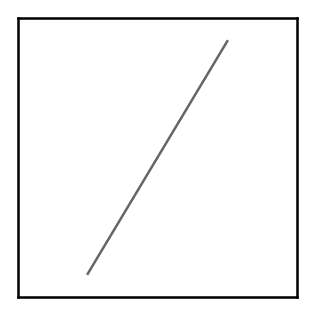

In [57]:
lineString1 = LineString(((-3, -5), (3, 5)))
print lineString1
plot(lineString1)


## There are also "multi" versions of everything: multipoint, multiline and multipolygon

## Now that we know the basics of what we have to manipulate, let's focus on shapes and look at what we can do with them.
<BR>
## First, let's talk about holes.

POLYGON ((1 1, 5 1, 5 5, 1 5, 1 1))
16.0


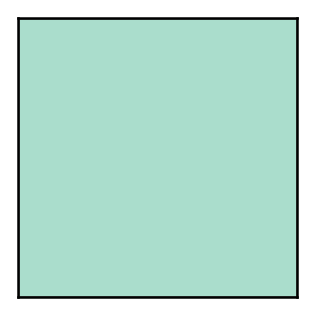

In [58]:
polygon0 = shapely.geometry.Polygon(
    ((1, 1), (5, 1), (5, 5), (1, 5), (1, 1)),      # Shell
)
print polygon0
print polygon0.area
plot(polygon0)


14.0
POLYGON ((1 1, 5 1, 5 5, 1 5, 1 1), (2 2, 2 3, 3 3, 3 2, 2 2), (3 3, 3 4, 4 4, 4 3, 3 3))


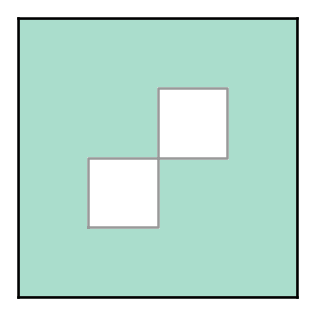

In [59]:
polygon1 = shapely.geometry.Polygon(
    ((1, 1), (5, 1), (5, 5), (1, 5), (1, 1)),      # Shell
    [
        ((2, 2), (2, 3), (3, 3), (3, 2), (2, 2)),  # Hole
        ((3, 3), (3, 4), (4, 4), (4, 3), (3, 3)),  # Hole
    ]
)
print polygon1.area
print polygon1
plot(polygon1)

You can use polygons to carve holes in other polygons.

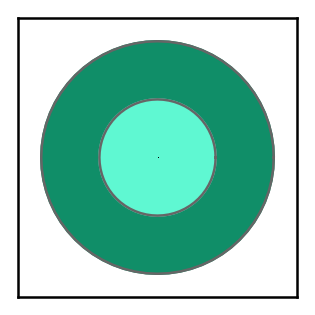

In [60]:
pt = Point(0,0)
circle =  pt.buffer(.5)
small_circle = pt.buffer(.25)
plot([circle, small_circle, pt], color_dict=None)

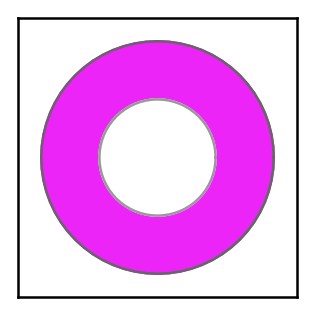

In [61]:
donut = circle.difference(small_circle)
plot(donut, color_dict=None)

## Next, you can combine polygons.
<BR>
## First, you can do a union on two shapes...

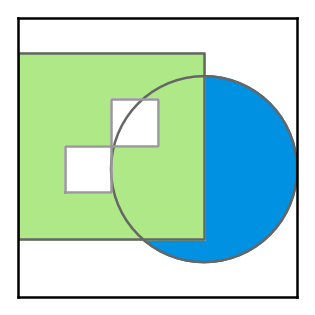

In [62]:
circle = Point(5,2.5).buffer(2)
plot([circle, polygon1], color_dict=None)

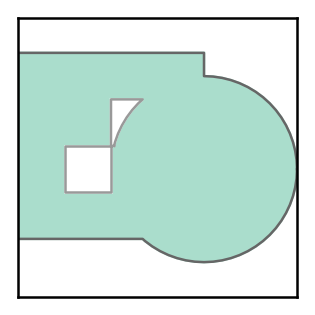

In [63]:
plot(circle.union(polygon1))

## You can also use unions to create multipolygons

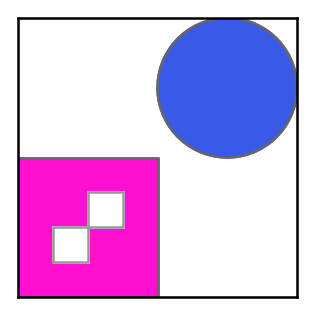

In [64]:
circle2 = Point(7,7).buffer(2)
plot([circle2, polygon1], color_dict=None)

MultiPolygon
CIRCLE AREA: 12.546194
POLYGON AREA: 14.000000
MULTIPOLYGON AREA: 26.546194


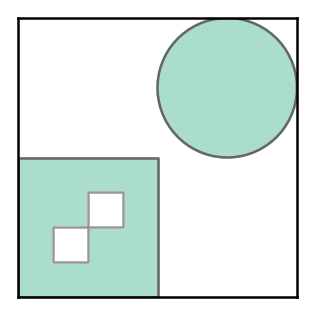

In [65]:


new_multipolygon = polygon1.union(circle2)
plot(new_multipolygon)
print new_multipolygon.type
print "CIRCLE AREA: %f" % (circle2.area)
print "POLYGON AREA: %f" % (polygon1.area)
print "MULTIPOLYGON AREA: %f" % (new_multipolygon.area)

## You can also union a bunch of shapes at once

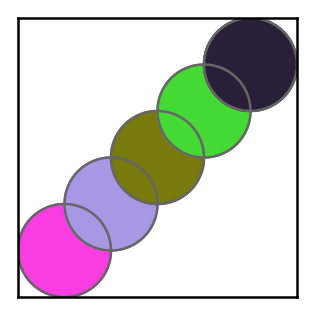

In [66]:
from shapely.ops import cascaded_union, unary_union
buffered_points_list = []

circle_set = range(5);
   
for x in circle_set:
    buffered_points_list.append(Point(x,x).buffer(1))


plot(buffered_points_list, color_dict=None)

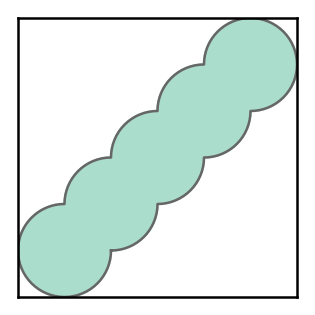

In [67]:
union_shape = cascaded_union(buffered_points_list)
plot(union_shape)